In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [2]:
import sys, os
sys.path.insert(0,'/Users/mbbssnw3/Dropbox (The University of Manchester)/ACTIVE/COURSE--OptContFinance/code/stochastic_control')
from stochastic_control.continuous_control.continuous_control import brownian_motion, Euler_Maruyama, MLMC, mlmc_iterations

## Simulation of Brownian Motion at 3 levels

In [3]:
times, BM = brownian_motion(accuracy=2**-8,levels=[1,8,16])

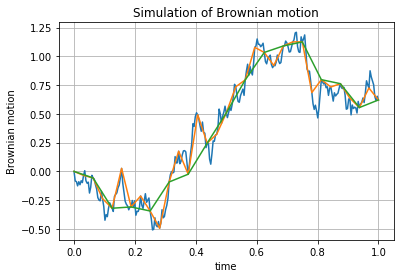

In [4]:
fig, ax = plt.subplots()

for key, value in BM.items():
    ax.plot(times[key],BM[key])

ax.set(xlabel='time', ylabel='Brownian motion',
       title='Simulation of Brownian motion')
ax.grid()
fig.savefig("test.png")
plt.show()

## Simulation of Geometric Brownian Motion

In [5]:
def gbm_mu(x,m=1):
    return m*x

def gbm_sigma(x,s=1):
    return s*x

def gbm_objective(path,times=None):
    return path[-1]

In [6]:
GBM = Euler_Maruyama(gbm_mu,gbm_sigma,x0=1.,accuracy=2**-8)
times, paths = GBM.sim_levels([2, 8, 16])

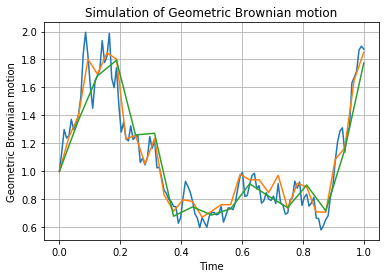

In [7]:
fig, ax = plt.subplots()

for key, value in paths.items():
    ax.plot(times[key],paths[key])

ax.set(xlabel='Time', ylabel='Geometric Brownian motion',
       title='Simulation of Geometric Brownian motion')
ax.grid()
fig.savefig("test.png")
plt.show()

## Estimate Multi-level Costs and Variances 

In [8]:
from time import time
from tqdm import tqdm

In [9]:
def gbm_mu(x,m=0.05):
    return m*x

def gbm_sigma(x,s=0.2):
    return s*x

def gbm_objective(path,times=None):
    return path[-1]

In [10]:
levels = [1,4,4**2,4**3,4**4, 4**5, 4**6] #16,32,64,128]
acc = 4**-8
EM = Euler_Maruyama(gbm_mu,gbm_sigma,x0=1.,accuracy=acc)

In [11]:
# This is a quick experiment estimating costs and MLMC variances at each level 
# We could extroplate with an exponential fit
num_samples = 100
Costs= np.zeros(len(levels))
Estimates= np.zeros(len(levels))
Estimates_sqrd = np.zeros(len(levels))

for _ in tqdm(range(num_samples)):

    # Brownian motion required as input
    times, BM = brownian_motion(accuracy=acc,levels=levels)
    for i, l in enumerate(reversed(levels)):
        #print(l)
        tic = time()
        path = EM.sim(times[l],BM[l])
        p = gbm_objective(path)
        toc = time()
        Costs[i] += toc-tic
        if i == 0 :
            Y = p
        else :
            Y = p - p_old
        p_old = p 
        Estimates[i] += Y
        Estimates_sqrd[i] += Y*Y     
        
Costs = Costs / num_samples
Variances = Estimates_sqrd / num_samples- np.multiply(Estimates/ num_samples,Estimates/ num_samples)
Costs = Costs[::-1]
Variances = Variances[::-1]       
L = np.arange(1,len(Variances)+1)

100%|██████████| 100/100 [00:32<00:00,  3.02it/s]


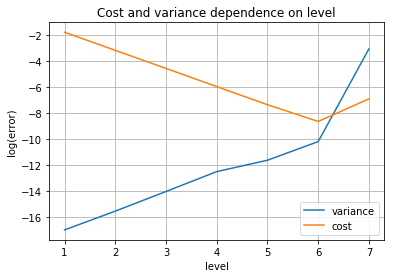

In [12]:
fig, ax = plt.subplots()

ax.plot(L,np.log(Variances),label='variance')
ax.plot(L,np.log(Costs),label='cost')

ax.set(xlabel='level', ylabel='log(error)',
       title='Cost and variance dependence on level')
plt.legend()
ax.grid()
fig.savefig("test.png")
plt.show()

In [13]:
# Given estimates above, calculate optimal iterations of RMS error epsilon
epsilon = 0.001
iterations, cost=mlmc_iterations(epsilon,Costs,Variances)
EM = Euler_Maruyama(gbm_mu,gbm_sigma,x0=1.,accuracy=acc)
print('iterations = ',iterations)
print('estimated cost (sec) = ', cost)
print('estimated standard deviation = ', np.sqrt(np.dot(Variances,1/iterations)))

iterations =  [    4    16    66   284   885  3451 51361]
estimated cost (sec) =  56.23260286820795
estimated standard deviation =  0.0009992491934031399


## Run MLMC

In [89]:
# Setup and run MLMC
mlmc=MLMC(levels,iterations,EM,gbm_objective)
estimate = mlmc.run()

print('mlmc estimate =',estimate)
print('true answer',np.exp(0.05))

53990it [00:15, 3451.10it/s]                           

mlmc estimate = 1.0521338620468093
true answer 1.0512710963760241


In [78]:
# # test variance is about right
# # DON't RUN FOR SMALL EPSILON
# data = []
# for _ in range(100):
#     data.append(mlmc.run())
#     clear_output(wait=True)
    
# print('estimated standard deviation =',np.sqrt(np.dot(Variances,1/iterations)))
# print('sample standard deviation =', np.std(data))
    

estimated standard deviation = 0.04804083809440864
sample standard deviation = 0.050225842714944124


## European Option

In [59]:
def gbm_mu(x,m=0.05):
    return m*x

def gbm_sigma(x,s=0.2):
    return s*x

def european_objective(path,times=None,m=0.05):
    return np.exp(-m) * max(path[-1]-1,0)

In [60]:
# Setup and run MLMC
mlmc=MLMC(levels,iterations,EM,european_objective)
mlmc.run()

100%|██████████| 58361/58361 [00:14<00:00, 3957.76it/s] 


0.10481324224388816

## Lookback Option

In [61]:
def gbm_mu(x,m=0.05):
    return m*x

def gbm_sigma(x,s=0.2):
    return s*x

def lookback_objective(path,times=None,m=0.05):
    return np.exp(-m) * ( path[-1]- np.min(path))

In [62]:
# Setup and run MLMC
mlmc=MLMC(levels,iterations,EM,gbm_objective)
mlmc.run()

100%|██████████| 58361/58361 [00:25<00:00, 2326.03it/s]


0.17235413233655544